In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import nn

from src.DRL.qnetwork import QNetwork
from src.Qrunner.qrunner import QrunnerEnv
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['random continuous']
sample_concept.prepare_data(env_steps)
test_obs = sample_concept.test_obs
test_images = sample_concept.test_images

In [4]:
model_path = QNetwork.find_newest_model()
#model_path = "runs/20240222-134350_task_0/model_1000000.pt"
model = QNetwork(frame_stacks=1, model_path=model_path)
layer = 4
print(f"Using model: {model_path} at layer: {layer}")

test_q_values, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
test_acts = test_acts_dict[layer].cpu().detach().numpy()
test_acts = test_acts.reshape(test_acts.shape[0], -1)

Using model: runs/20240224-103820_task_0/model_10000000.pt at layer: 4


In [5]:
concept_cavs = {}
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if score > 0.8:
        cav = probe[1].weight.data.cpu().numpy().squeeze()
        concept_cavs[concept.name] = cav
        print(f"{concept.name:^35} | {score:^10.4f} | yes")
    else:
        print(f"{concept.name:^35} | {score:^10.4f} | no")

           random binary            |   0.0230   | no
         random continuous          |   0.0180   | no
            player low              |   0.9900   | yes
            difficulty              |   0.9240   | yes
           player in air            |   0.9650   | yes
       player dodging in air        |   0.8910   | yes
      player standing on wall       |   0.9480   | yes
      player dodging on wall        |   0.8290   | yes
          events quantity           |   0.7930   | no
           visible wall             |   0.9180   | yes
          visible bullet            |   0.9160   | yes
           visible lava             |   0.9670   | yes
           coin quantity            |   0.7160   | no
        good visible events         |   0.7570   | no
        bad visible events          |   0.8880   | yes
           bullet close             |   0.7970   | no
    bullet aligned with player      |   0.7740   | no
          player dodging            |   0.9460   | yes
          coin ab

In [6]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def action_name(action_idx):
    return QrunnerEnv.get_action_meanings()[action_idx]

In [7]:
from collections import Counter


def get_CFE(original_idx):
    original_obs = test_obs[original_idx]
    original_img = test_images[original_idx]
    original_q_values = test_q_values[original_idx].cpu().detach().numpy()
    original_action = action_name(np.argmax(original_q_values))
    original_acts = test_acts[original_idx]
    
    similarities = []
    for i, other_acts in enumerate(test_acts):
        if i == original_idx or action_name(np.argmax(test_q_values[i].cpu().detach().numpy())) == original_action:
            continue
        sim = cosine_similarity(original_acts, other_acts)
        similarities.append((i, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    #plt.plot([sim for _, sim in similarities[:200]])
    #plt.show()

    n = 200
    top_n_indices = [idx for idx, _ in similarities[:n]]

    actions = [action_name(np.argmax(test_q_values[i].cpu().detach().numpy())) for i in top_n_indices]
    most_common_action, _ = Counter(actions).most_common(1)[0]

    other_action_examples = [i for i in top_n_indices if action_name(np.argmax(test_q_values[i].cpu().detach().numpy())) == most_common_action]
    number_of_examples = len(other_action_examples)
    other_action = most_common_action
    
    '''
    print(f"Original action: {original_action}")
    print(f"Other action: {other_action}")
    print(f"Number of other action examples: {number_of_examples}")
    '''
    
    negative_to_positive = []
    positive_to_negative = []
    for i in other_action_examples:
        for concept, cav in concept_cavs.items():
            original_sim = cosine_similarity(original_acts, cav)
            other_sim = cosine_similarity(test_acts[i], cav)

            if np.sign(original_sim) != np.sign(other_sim):
                if original_sim < 0:
                    negative_to_positive.append(concept)
                else:
                    positive_to_negative.append(concept)
                
    freq_negative_to_positive = Counter(negative_to_positive)
    freq_positive_to_negative = Counter(positive_to_negative)
    
    print(f"Frequency of negative to positive: {freq_negative_to_positive}")
    print(f"Frequency of positive to negative: {freq_positive_to_negative}")

    # Check if count/number_of_examples > threshold
    threshold = 0.5
    positive_relevant_concepts = [concept for concept, count in freq_negative_to_positive.items() if count/number_of_examples >= threshold][:2]
    negative_relevant_concepts = [concept for concept, count in freq_positive_to_negative.items() if count/number_of_examples >= threshold][:2]
    # Constructing the conditional sentence parts based on the list contents
    positive_part = f"more ({', '.join(positive_relevant_concepts)})" if positive_relevant_concepts else ""
    negative_part = f"less ({', '.join(negative_relevant_concepts)})" if negative_relevant_concepts else ""

    # Combining the parts with proper language structure
    condition_parts = []
    if positive_part:
        condition_parts.append(positive_part)
    if negative_part:
        condition_parts.append(negative_part)

    condition_sentence = ", and ".join(condition_parts)

    print(f"If there was {condition_sentence}, then the agent would do ({other_action}) instead of ({original_action})")
        
    plt.imshow(original_img)
    plt.axis('off')
    plt.show()

Example 4778
Frequency of negative to positive: Counter({'visible wall': 132, 'player in air': 40, 'reachable good coin': 32, 'unreachable good coin': 11, 'visible bullet': 3, 'player dodging in air': 1, 'player dodging': 1})
Frequency of positive to negative: Counter({'visible lava': 106, 'bad visible events': 17})
If there was more (visible wall), and less (visible lava), then the agent would do (RIGHT) instead of (JUMP)


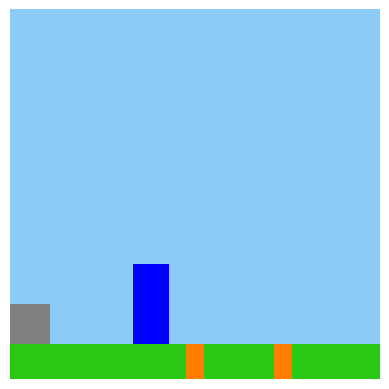

In [124]:
ex_idx = random.randint(0, len(test_obs)-1)
print(f"Example {ex_idx}")
get_CFE(ex_idx)